In [1]:
import numpy as np
import cv2
import os
import pandas as pd
import string
import matplotlib.pyplot as plt

import os

from tensorflow.keras.preprocessing.sequence import pad_sequences

from keras.layers import Dense, LSTM, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional
from keras.models import Model
from keras.activations import relu, sigmoid, softmax
import keras.backend as K
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras_tqdm import TQDMNotebookCallback

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [2]:
alphabet = list('abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ')
with open(r'C:\Users\rgopi\Desktop\tcsion_internship\database\ascii\words.txt') as f:
    contents = f.readlines()

lines = [line.strip() for line in contents if line[0] in alphabet] 
lines[0]


'a01-000u-00-00 ok 154 408 768 27 51 AT A'

In [3]:
max_label_len = 0

char_list = "!\"#&'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz" 

# string.ascii_letters + string.digits (Chars & Digits)
# or 
# "!\"#&'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"

print(char_list, len(char_list))

def encode_to_labels(txt):
    # encoding each output word into digits
    dig_lst = []
    for index, chara in enumerate(txt):
        dig_lst.append(char_list.index(chara))
        
    return dig_lst


!"#&'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz 78


In [4]:
images = []
labels = []

RECORDS_COUNT = 10000

train_images = []
train_labels = []
train_input_length = []
train_label_length = []
train_original_text = []

valid_images = []
valid_labels = []
valid_input_length = []
valid_label_length = []
valid_original_text = []

inputs_length = []
labels_length = []

In [5]:
def process_image(img):
    """
    Converts image to shape (32, 128, 1) & normalize
    """
    w, h = img.shape
    
#     _, img = cv2.threshold(img, 
#                            128, 
#                            255, 
#                            cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    
    # Aspect Ratio Calculation
    new_w = 32
    new_h = int(h * (new_w / w))
    img = cv2.resize(img, (new_h, new_w))
    w, h = img.shape
    
    img = img.astype('float32')
    
    # Converts each to (32, 128, 1)
    if w < 32:
        add_zeros = np.full((32-w, h), 255)
        img = np.concatenate((img, add_zeros))
        w, h = img.shape
    
    if h < 128:
        add_zeros = np.full((w, 128-h), 255)
        img = np.concatenate((img, add_zeros), axis=1)
        w, h = img.shape
        
    if h > 128 or w > 32:
        dim = (128,32)
        img = cv2.resize(img, dim)
    
    img = cv2.subtract(255, img)
    
    img = np.expand_dims(img, axis=2)
    
    # Normalize 
    img = img / 255
    
    return img

In [6]:
for index, line in enumerate(lines):
    splits = line.split(' ')
    status = splits[1]
    
    if status == 'ok':
        word_id = splits[0]
        word = "".join(splits[8:])
        
        splits_id = word_id.split('-')
        filepath = r'C:\Users\rgopi\Desktop\tcsion_internship\database\words\{}\{}-{}\{}.png'.format(splits_id[0], 
                                                  splits_id[0], 
                                                  splits_id[1], 
                                                  word_id)
        
        # processing on image
        img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
        try:
            img = process_image(img)
        except:
            continue
            
        # processing on label
        try:
            label = encode_to_labels(word)
        except:
            continue
        
        if index % 10 == 0:
            valid_images.append(img)
            valid_labels.append(label)
            valid_input_length.append(31)
            valid_label_length.append(len(word))
            valid_original_text.append(word)
        else:
            train_images.append(img)
            train_labels.append(label)
            train_input_length.append(31)
            train_label_length.append(len(word))
            train_original_text.append(word)
        
        if len(word) > max_label_len:
            max_label_len = len(word)
    
    if index >= RECORDS_COUNT:
        break

In [7]:
train_padded_label = pad_sequences(train_labels, 
                             maxlen=max_label_len, 
                             padding='post',
                             value=len(char_list))

valid_padded_label = pad_sequences(valid_labels, 
                             maxlen=max_label_len, 
                             padding='post',
                             value=len(char_list))

In [8]:
train_padded_label.shape, valid_padded_label.shape

((7850, 16), (876, 16))

In [9]:
train_images[0][0]

array([[0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.   

In [10]:
train_images = np.asarray(train_images)
train_input_length = np.asarray(train_input_length)
train_label_length = np.asarray(train_label_length)

valid_images = np.asarray(valid_images)
valid_input_length = np.asarray(valid_input_length)
valid_label_length = np.asarray(valid_label_length)

In [11]:
train_images[0][0]

array([[0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.   

In [12]:

# input with shape of height=32 and width=128 
inputs = Input(shape=(32,128,1))
 
# convolution layer with kernel size (3,3)
conv_1 = Conv2D(64, (3,3), activation = 'relu', padding='same')(inputs)
# poolig layer with kernel size (2,2)
pool_1 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_1)
 
conv_2 = Conv2D(128, (3,3), activation = 'relu', padding='same')(pool_1)
pool_2 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_2)
 
conv_3 = Conv2D(256, (3,3), activation = 'relu', padding='same')(pool_2)
 
conv_4 = Conv2D(256, (3,3), activation = 'relu', padding='same')(conv_3)

# poolig layer with kernel size (2,1)
pool_4 = MaxPool2D(pool_size=(2, 1))(conv_4)
 
conv_5 = Conv2D(512, (3,3), activation = 'relu', padding='same')(pool_4)

# Batch normalization layer
batch_norm_5 = BatchNormalization()(conv_5)
 
conv_6 = Conv2D(512, (3,3), activation = 'relu', padding='same')(batch_norm_5)
batch_norm_6 = BatchNormalization()(conv_6)
pool_6 = MaxPool2D(pool_size=(2, 1))(batch_norm_6)
 
conv_7 = Conv2D(512, (2,2), activation = 'relu')(pool_6)
 
squeezed = Lambda(lambda x: K.squeeze(x, 1))(conv_7)
 
# bidirectional LSTM layers with units=128
blstm_1 = Bidirectional(LSTM(256, return_sequences=True, dropout = 0.2))(squeezed)
blstm_2 = Bidirectional(LSTM(256, return_sequences=True, dropout = 0.2))(blstm_1)
 
outputs = Dense(len(char_list)+1, activation = 'softmax')(blstm_2)

# model to be used at test time
act_model = Model(inputs, outputs)

In [13]:
act_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 128, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 32, 128, 64)       640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 64, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 64, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 32, 128)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 32, 256)        295168

In [14]:
the_labels = Input(name='the_labels', shape=[max_label_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([outputs, the_labels, input_length, label_length])

#model to be used at training time
model = Model(inputs=[inputs, the_labels, input_length, label_length], outputs=loss_out)
     

In [15]:
batch_size = 8
epochs = 30
e = str(epochs)
optimizer_name = 'sgd'
     

In [17]:
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer = optimizer_name, metrics=['accuracy'])

filepath=r"C:\Users\rgopi\Desktop\tcsion_internship\training_models\{}o-{}r-{}e-{}t-{}v.hdf5".format(optimizer_name,
                                          str(RECORDS_COUNT),
                                          str(epochs),
                                          str(train_images.shape[0]),
                                          str(valid_images.shape[0]))

checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
callbacks_list = [checkpoint]

In [18]:
history = model.fit(x=[train_images, train_padded_label, train_input_length, train_label_length],
                    y=np.zeros(len(train_images)),
                    batch_size=batch_size, 
                    epochs=epochs, 
                    validation_data=([valid_images, valid_padded_label, valid_input_length, valid_label_length], [np.zeros(len(valid_images))]),
                    verbose=2,
                    callbacks=callbacks_list)

Epoch 1/30
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089

Epoch 1: val_loss improved from inf to 15.17772, saving model to C:\Users\rgopi\Desktop\tcsion_internship\training_models\sgdo-10000r-30e-7850t-876v.hdf5
982/982 - 445s - loss: 15.4570 - accuracy: 0.0000e+00 - val_loss: 15.1777 - val_accuracy: 0.0000e+00 - 445s/epoch - 453ms/step
Epoch 2/30

Epoch 2: val_loss improved from 15.17772 to 12.09377, saving model to C:\Users\rgopi\Desktop\tcsion_internship\training_models\sgdo-10000r-30e-7850t-876v.hdf5
982/982 - 428s - loss: 12.7610 - accuracy: 0.0201 - val_loss: 12.0938 - val_accuracy: 0.0514 - 428s/epoch - 435ms/step
Epoch 3/30

Epoch 3: val_loss improved from 12.09377 to 9.99046, saving model to C:\Users\rgopi\Desktop\tcsion_internship\training_models\sgdo-10000r-30e-7850t-876v.hdf5
982/982 - 457s - loss: 10.6995 - accuracy: 0.0

In [20]:

# load the saved best model weights
act_model.load_weights(filepath)
# predict outputs on validation images
prediction = act_model.predict(valid_images)
 
# use CTC decoder
decoded = K.ctc_decode(prediction, 
                       input_length=np.ones(prediction.shape[0]) * prediction.shape[1],
                       greedy=True)[0][0]
out = K.get_value(decoded)

28/28 [==============================] - 9s 252ms/step


In [22]:
!pip install python-levenshtein


In [24]:
import Levenshtein as lv
total_jaro = 0
total_rati = 0
# see the results
for i, x in enumerate(out):
    letters=''
    for p in x:
        if int(p) != -1:
            letters+=char_list[int(p)]
    total_jaro+=lv.jaro(letters, valid_original_text[i])
    total_rati+=lv.ratio(letters, valid_original_text[i])

print('jaro :', total_jaro/len(out))
print('ratio:', total_rati/len(out))

jaro : 0.9110530461843253
ratio: 0.8794709856215808


4/4 [==============================] - 1s 187ms/step
the original text =   the
the predicted text from the model = the

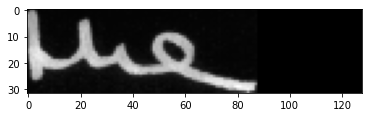



the original text =   Colonial
the predicted text from the model = Colonial

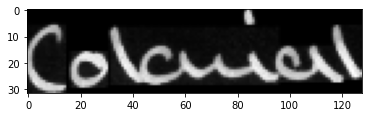



the original text =   Secretary
the predicted text from the model = Secretary

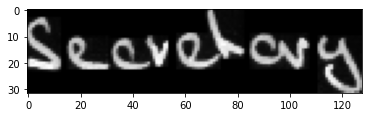



the original text =   ,
the predicted text from the model = ,

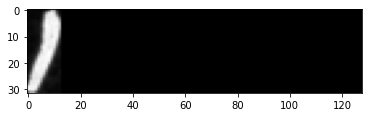



the original text =   Mr.
the predicted text from the model = Mr.

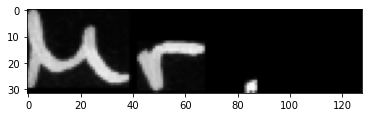



the original text =   Iain
the predicted text from the model = Iain

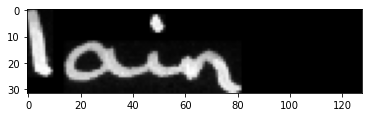



the original text =   Macleod
the predicted text from the model = Macleod

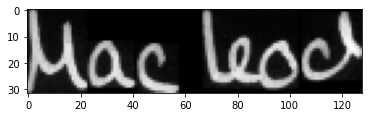



the original text =   is
the predicted text from the model = is

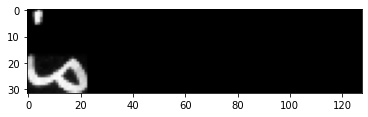



the original text =   insisting
the predicted text from the model = insinsting

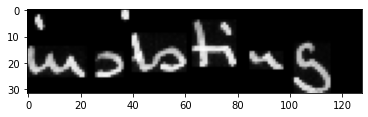



the original text =   on
the predicted text from the model = on

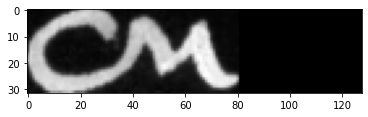



the original text =   a
the predicted text from the model = a

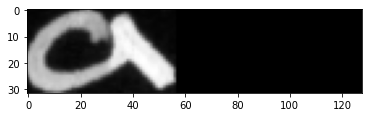



the original text =   policy
the predicted text from the model = policy

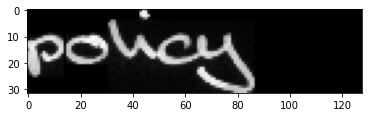



the original text =   of
the predicted text from the model = of

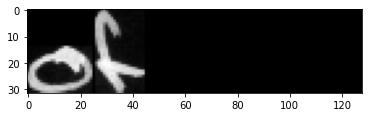



the original text =   change
the predicted text from the model = change

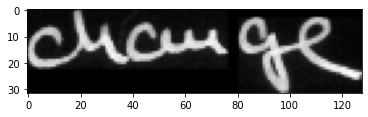



the original text =   .
the predicted text from the model = .

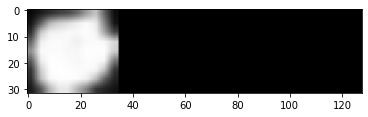



the original text =   Macleod
the predicted text from the model = Macleod

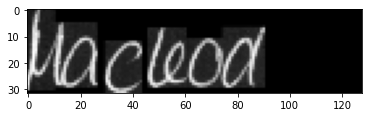



the original text =   ,
the predicted text from the model = ,

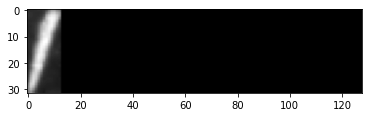



the original text =   is
the predicted text from the model = is

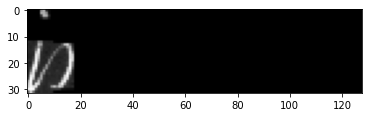



the original text =   on
the predicted text from the model = on

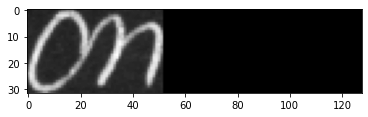



the original text =   a
the predicted text from the model = a

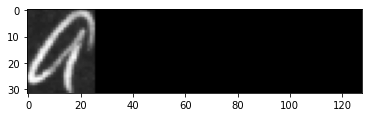



the original text =   policy
the predicted text from the model = policy

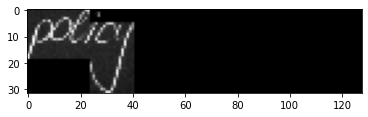



the original text =   of
the predicted text from the model = of

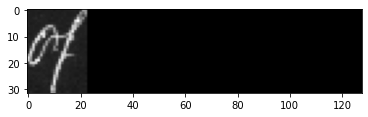



the original text =   change
the predicted text from the model = change

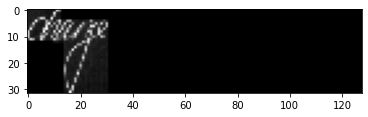



the original text =   .
the predicted text from the model = .

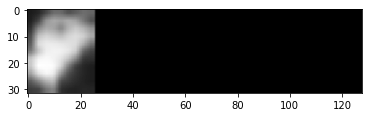



the original text =   Sir
the predicted text from the model = Sir

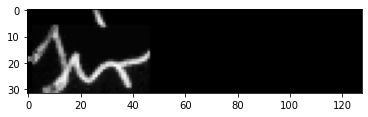



the original text =   Roy's
the predicted text from the model = Roy's

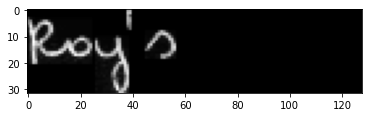



the original text =   United
the predicted text from the model = United

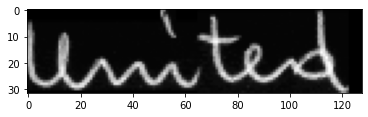



the original text =   Party
the predicted text from the model = Party

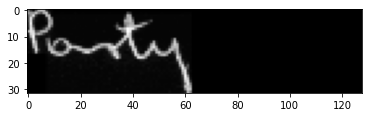



the original text =   is
the predicted text from the model = is

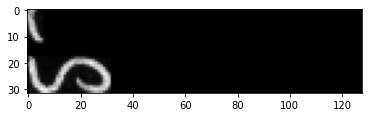



the original text =   boycotting
the predicted text from the model = boycotting

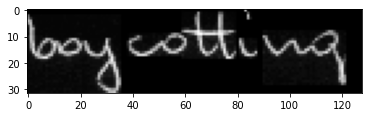



the original text =   the
the predicted text from the model = the

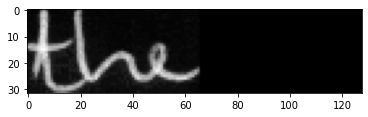



the original text =   London
the predicted text from the model = London

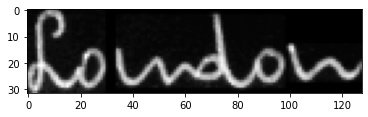



the original text =   talks
the predicted text from the model = talks

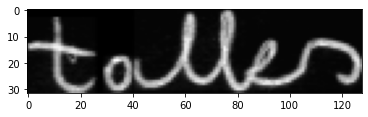



the original text =   on
the predicted text from the model = on

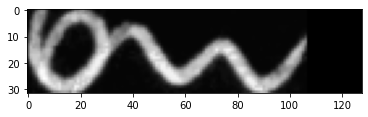



the original text =   the
the predicted text from the model = the

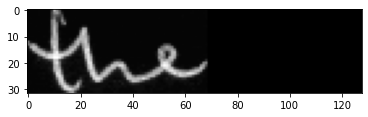



the original text =   Protectorate's
the predicted text from the model = Protectorate's

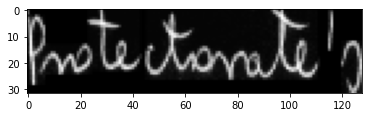



the original text =   .
the predicted text from the model = .

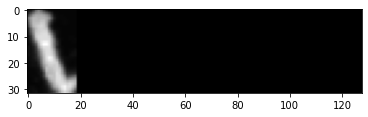



the original text =   Said
the predicted text from the model = Said

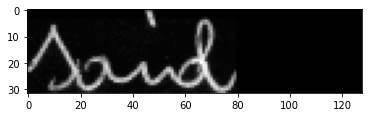



the original text =   Mr.
the predicted text from the model = Mr.

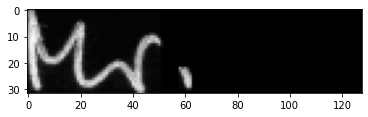



the original text =   Nkumbula
the predicted text from the model = Nkumbula

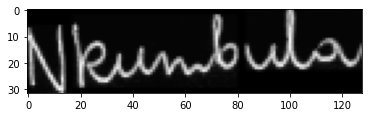



the original text =   last
the predicted text from the model = last

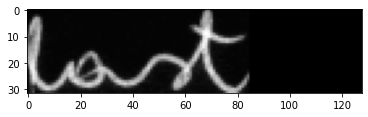



the original text =   night
the predicted text from the model = night

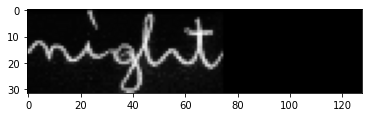



the original text =   :
the predicted text from the model = :

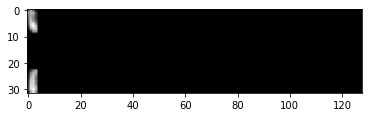



the original text =   "
the predicted text from the model = "

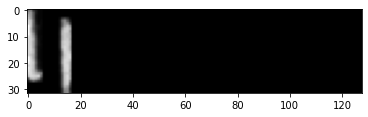



the original text =   We
the predicted text from the model = We

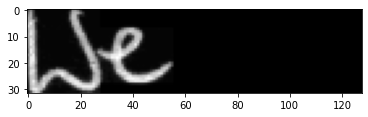



the original text =   to
the predicted text from the model = to

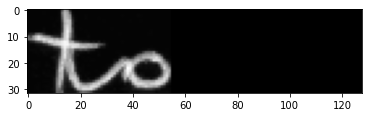



the original text =   discuss
the predicted text from the model = discuss

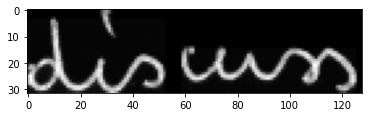



the original text =   what
the predicted text from the model = what

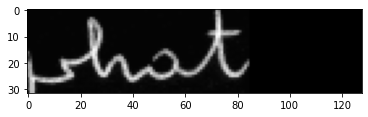



the original text =   to
the predicted text from the model = to

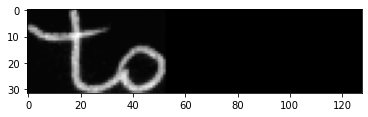



the original text =   do
the predicted text from the model = do

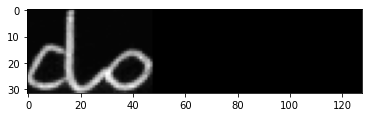



the original text =   if
the predicted text from the model = if

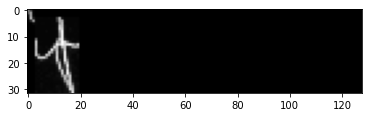



the original text =   the
the predicted text from the model = the

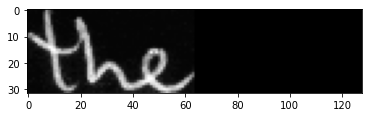



the original text =   British
the predicted text from the model = British

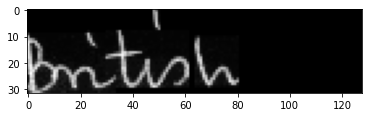



the original text =   Government
the predicted text from the model = Government

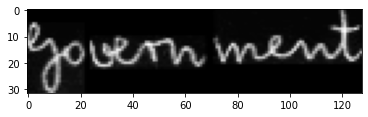



the original text =   in
the predicted text from the model = in

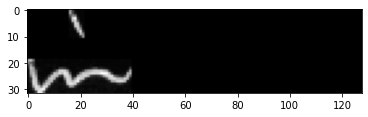



the original text =   to
the predicted text from the model = to

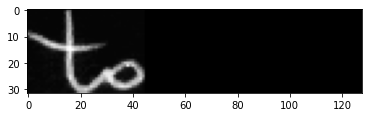



the original text =   Sir
the predicted text from the model = Sir

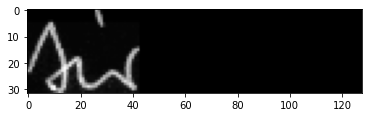



the original text =   Roy
the predicted text from the model = Roy

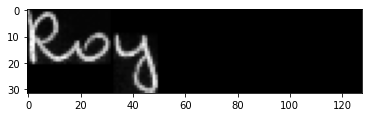



the original text =   and
the predicted text from the model = and

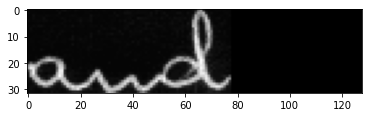



the original text =   the
the predicted text from the model = the

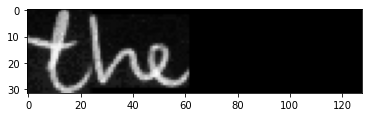



the original text =   talks
the predicted text from the model = talks

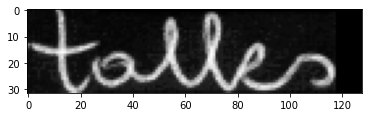



the original text =   fall
the predicted text from the model = fall

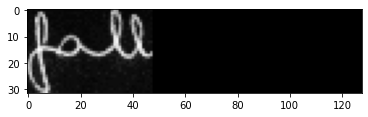



the original text =   through
the predicted text from the model = through

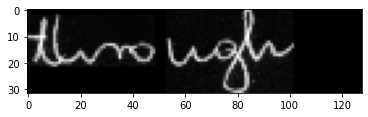



the original text =   There
the predicted text from the model = There

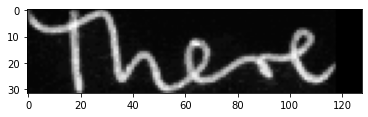



the original text =   are
the predicted text from the model = are

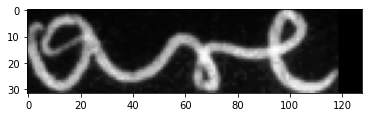



the original text =   bound
the predicted text from the model = bound

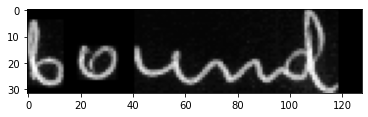



the original text =   chief
the predicted text from the model = chief

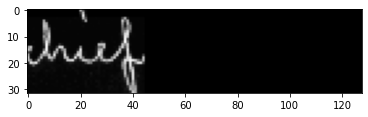



the original text =   aide
the predicted text from the model = aide

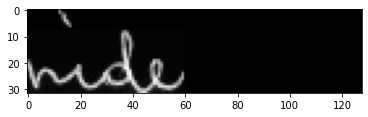



the original text =   ,
the predicted text from the model = ,

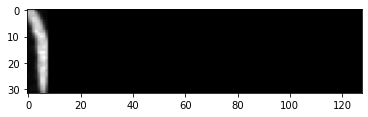



the original text =   Mr.
the predicted text from the model = Mr.

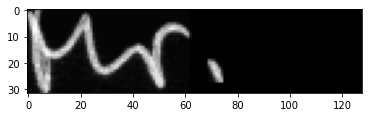



the original text =   Julius
the predicted text from the model = Julius

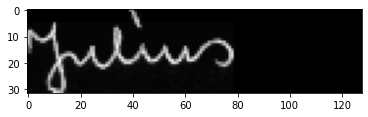



the original text =   Greenfield
the predicted text from the model = Greenfield

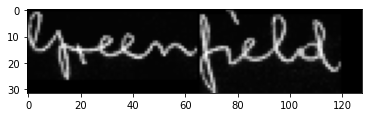



the original text =   ,
the predicted text from the model = ,

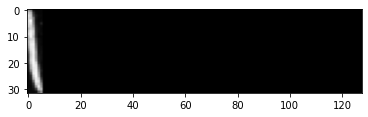



the original text =   telephoned
the predicted text from the model = telephoned

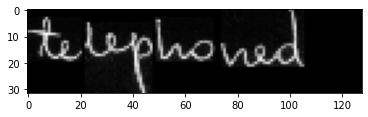



the original text =   chief
the predicted text from the model = chief

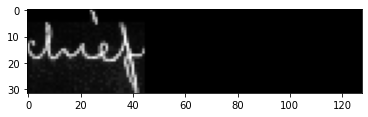



the original text =   a
the predicted text from the model = a

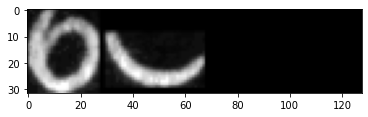



the original text =   report
the predicted text from the model = report

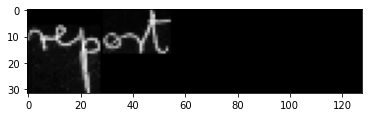



the original text =   on
the predicted text from the model = on

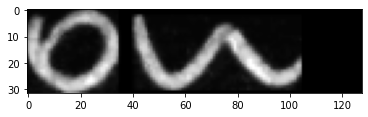



the original text =   his
the predicted text from the model = his

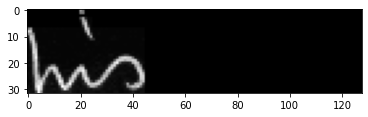



the original text =   talks
the predicted text from the model = talks

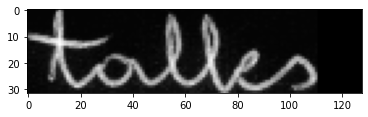



the original text =   with
the predicted text from the model = with

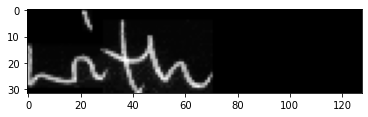



the original text =   Mr.
the predicted text from the model = Mr.

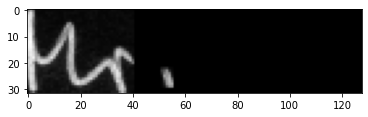



the original text =   Macmillan
the predicted text from the model = Macmillan

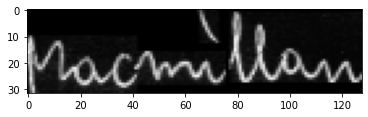



the original text =   Chequers
the predicted text from the model = Chequers

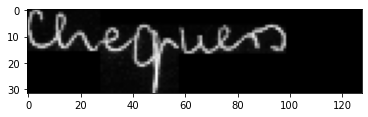



the original text =   .
the predicted text from the model = .

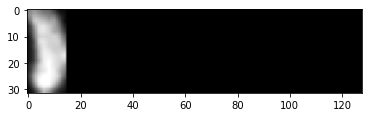



the original text =   Sir
the predicted text from the model = Sir

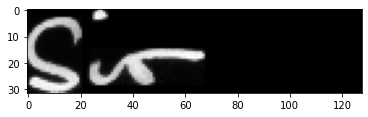



the original text =   Roy's
the predicted text from the model = Roy's

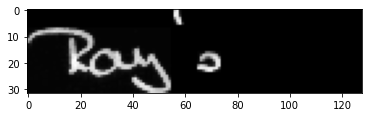



the original text =   United
the predicted text from the model = United

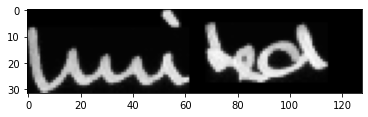



the original text =   Federal
the predicted text from the model = Federal

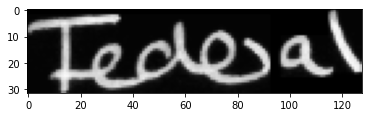



the original text =   Party
the predicted text from the model = Party

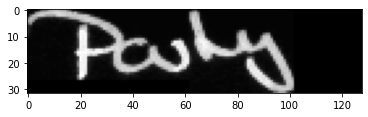



the original text =   is
the predicted text from the model = is

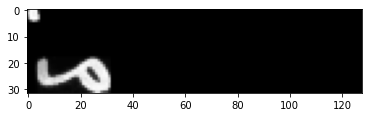



the original text =   boycotting
the predicted text from the model = boycotting

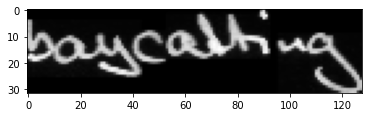



the original text =   London
the predicted text from the model = London

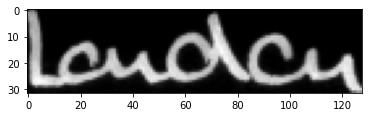



the original text =   talks
the predicted text from the model = talks

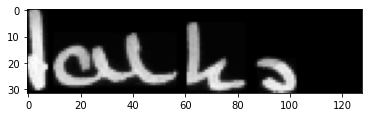



the original text =   on
the predicted text from the model = on

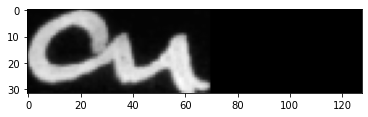



the original text =   the
the predicted text from the model = the

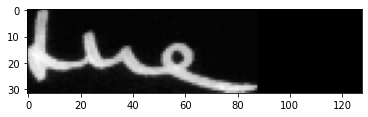



the original text =   last
the predicted text from the model = last

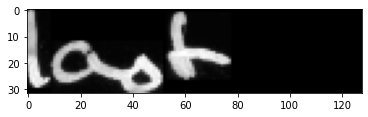



the original text =   night
the predicted text from the model = night

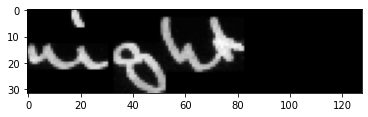



the original text =   :
the predicted text from the model = :

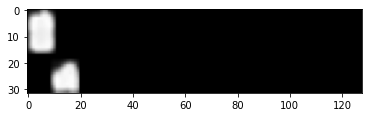



the original text =   "
the predicted text from the model = "

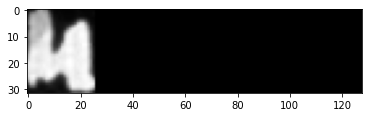



the original text =   We
the predicted text from the model = We

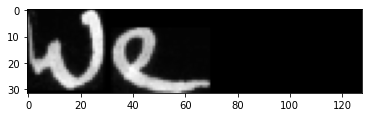



the original text =   want
the predicted text from the model = want

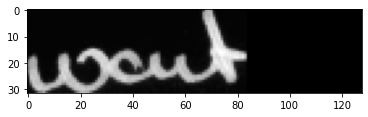



the original text =   to
the predicted text from the model = to

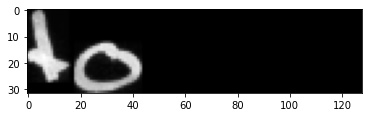

In [26]:
# predict outputs on validation images
prediction =act_model.predict(train_images[542:645])
 
# use CTC decoder
decoded = K.ctc_decode(prediction,   
                       input_length=np.ones(prediction.shape[0]) * prediction.shape[1],
                       greedy=True)[0][0]

out = K.get_value(decoded)

# see the results
for i, x in enumerate(out):
    print("the original text =  ", train_original_text[542+i])
    print("the predicted text from the model = ", end = '')
    for p in x:
        if int(p) != -1:
            print(char_list[int(p)], end = '')
    plt.imshow(train_images[542+i].reshape(32,128), cmap=plt.cm.gray)
    plt.show()
    print('\n')

In [27]:
def plotgraph(epochs, acc, val_acc):
    # Plot training & validation accuracy values
    plt.plot(epochs, acc, 'b')
    plt.plot(epochs, val_acc, 'r')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

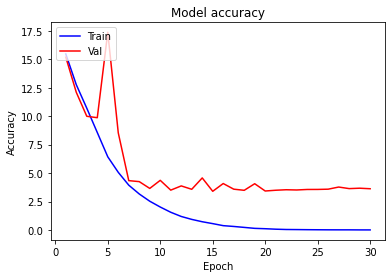

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(loss)+1)
plotgraph(epochs, loss, val_loss)

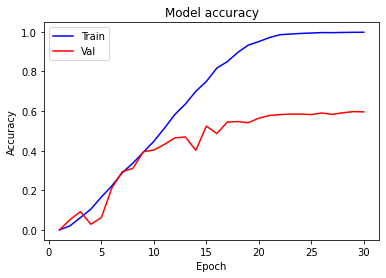

In [30]:

plotgraph(epochs, acc, val_acc)

In [31]:
minimum_val_loss = np.min(history.history['val_loss'])
best_model_index = np.where(history.history['val_loss'] == minimum_val_loss)[0][0]

best_loss = str(history.history['loss'][best_model_index])
best_acc = str(history.history['accuracy'][best_model_index])
best_val_loss = str(history.history['val_loss'][best_model_index])
best_val_acc = str(history.history['val_accuracy'][best_model_index])
     

In [34]:
with open(r'C:\Users\rgopi\Desktop\tcsion_internship\training_models\history.txt', 'a') as f:
    new_data = '{},{},{},{},{},{},{},{},{},{}\n'.format(filepath, 
                                                      optimizer_name, 
                                                      str(RECORDS_COUNT), 
                                                      e, 
                                                      str(train_images.shape[0]),
                                                      str(valid_images.shape[0]), 
                                                      best_loss, 
                                                      best_acc, 
                                                      best_val_loss, 
                                                      best_val_acc)

In [36]:
model.save(r'C:\Users\rgopi\Desktop\tcsion_internship\training_models\Text_recognizer_Using_CRNN.h5')